In [1]:
%load_ext autoreload


In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.optimize as op
from scipy.stats import ks_2samp
import cmasher as cmr
sys.path.append('/home/s86932rs/research/psrcelery/')
import psrcelery
from all_prof_functions import (bin_array, get_rms_bline,# check_null_prob, 
                                calc_snr, _find_off_pulse,
                                err_eigval, err_eigval_off, find_dists_outliers, rolling_out_rej,
                                bad_mjds_eigs)

#try:
#    from all_prof_functions import check_null_prob
#except OSError:
#    print("Could not import nulling analysis function")

%aimport -os -sys -np -plt -sklearn.preprocessing -sklearn.decomposition -cmr -op -ks_2samp
%autoreload 2


In [3]:
#plt.rcParams

In [4]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
use_bk_bgd = True #### Change this to use white backgrounds for plots  #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)


The following cell contains variables describing the dataset and where the data are located. Change them as needed. 

In [5]:
data_dir = '/home/s86932rs/research/nudot_stuff/'
plots_dir = os.path.join(data_dir, 'plots')
psr = 'J2043+2740'
freq = 1400
be = 'afb'


In [6]:
be = be.lower()
BE = be.upper()
desc = '{}_{}_{}'.format(psr, be, freq)
# read data from `step_1_clean_align`
# files contain ([AD]FB_aligned, [AD]FB_mjds_new, [AD]FB_tobs, [AD]FB_temp, [AD]FB_null_prob, [AD]FB_mjds_null)
npz_file = os.path.join(data_dir, '{}_{}_arrs.npz'.format(psr, freq))
with np.load(npz_file, allow_pickle=True) as d:
    exist_BE = False
    if BE not in d.keys() and BE+'_aligned' in d.keys():
        exist_BE = True
        BE_aligned = d[BE+'_aligned']
        if BE+'_temp' in d.keys():
            BE_temp = d[BE+'_temp']
        elif BE+'_template' in d.keys():
            BE_temp = d[BE+'_template']
        else:
            BE_temp = d[BE+'_template']
            
        if BE+'_mjds_new' in d.keys():
            BE_mjds_new = d[BE+'_mjds_new']
        else:
            BE_mjds_new = d[BE+'_mjds']
            
        if BE+'_tobs' in d.keys():
            BE_tobs = d[BE+'_tobs']
            
        if BE+'_nulling' not in d.keys() and BE+'_null_prob' in d.keys():
            BE_null_prob = d[BE+'_null_prob']
            BE_null_mjds = d[BE+'_mjds_null']
            
if exist_BE:
    print("The number of {} observations is {}, with {} bins, for a shape of {}.".format(BE, len(BE_mjds_new), len(BE_temp), BE_aligned.shape))
    if len(BE_mjds_new) < 100:
        print("This dataset is too small for final purpose; skipping")
        exist_BE = False
else:
    print("There are no {} data to analyse".format(BE))


The number of AFB observations is 275, with 400 bins, for a shape of (400, 275).


In [7]:
# this should no longer be necessary
if exist_BE and np.any(sorted(BE_mjds_new) != BE_mjds_new):
    print(BE+" MJDs are not sorted!!")
    sort_inds = np.argsort(BE_mjds_new)
    BE_mjds_new = BE_mjds_new[sort_inds]
    BE_aligned_new = BE_aligned[:,sort_inds]
    if BE_aligned_new.shape == BE_aligned.shape:
        BE_aligned = BE_aligned_new
        
    if np.any(sorted(BE_mjds_new) != BE_mjds_new):
        print("Sorting failed!!!!")
    

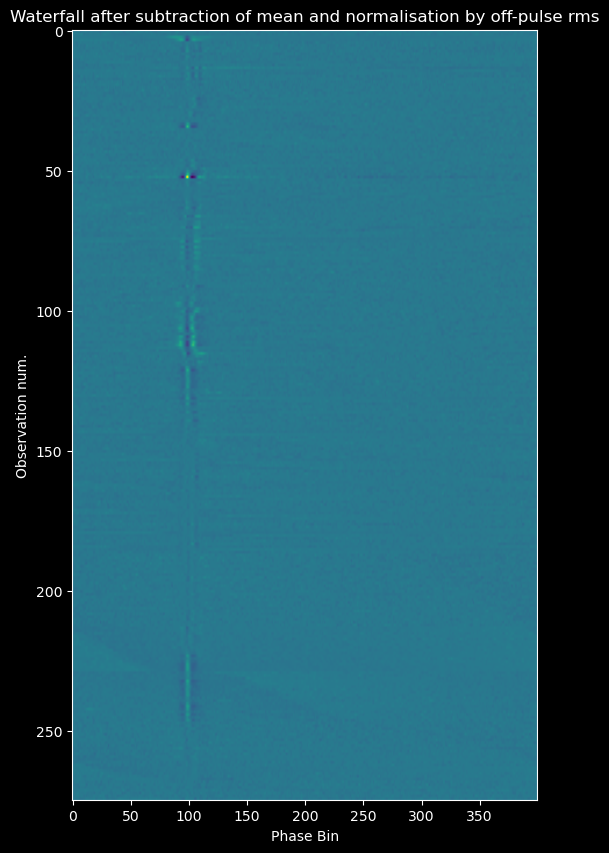

In [8]:
# Mike's alignment function # Been moved to the step_1 alignment function
if exist_BE:
    #plt.plot(BE_aligned[:,100])   
    #BE_aligned = psrcelery.data.align_and_scale(BE_aligned.T, BE_temp, nharm='auto').T
    #plt.plot(BE_aligned[:,100])   
    #plt.show()

    BE_off, _ = _find_off_pulse(BE_temp)
    BE_offrms = np.std(BE_aligned[BE_off,:], axis=0)
    BE_aligned = (BE_aligned.T - BE_temp).T/BE_offrms
    #plt.plot(BE_aligned[:,100])   
    #plt.show()
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(6, 10)
        plt.imshow(BE_aligned.T, aspect='auto')
        plt.ylabel('Observation num.')
        plt.xlabel('Phase Bin')
        plt.title('Waterfall after subtraction of mean and normalisation by off-pulse rms')
        plt.show()


In [9]:
# Try to set the phase cuts automatically
nbin = len(BE_temp)
lim, _ = _find_off_pulse(BE_temp)
phase = np.linspace(0, 1, nbin)

# define on-pulse ranges as fractions
ip_exist = len(phase[phase > 0.65]) != len(phase[BE_off][phase[BE_off] > 0.65]) # all points near IP are "off-pulse"
one_bin = 1/nbin
peak_min = np.max(phase[lim][phase[lim] < 0.25])-2*one_bin
peak_max = np.min(phase[lim][phase[lim] > 0.25])+2*one_bin
off_min = peak_min - min(peak_min/2, 0.03)
off_max = min(2*peak_max - peak_min, 0.65)
if ip_exist:
    ip_midd = np.mean(phase[np.logical_and(BE_off, phase >= 0.65)])
    ip_min = np.max(phase[lim][phase[lim] < ip_midd])-2*one_bin
    ip_max = np.min(phase[lim][phase[lim] > ip_midd])+2*one_bin


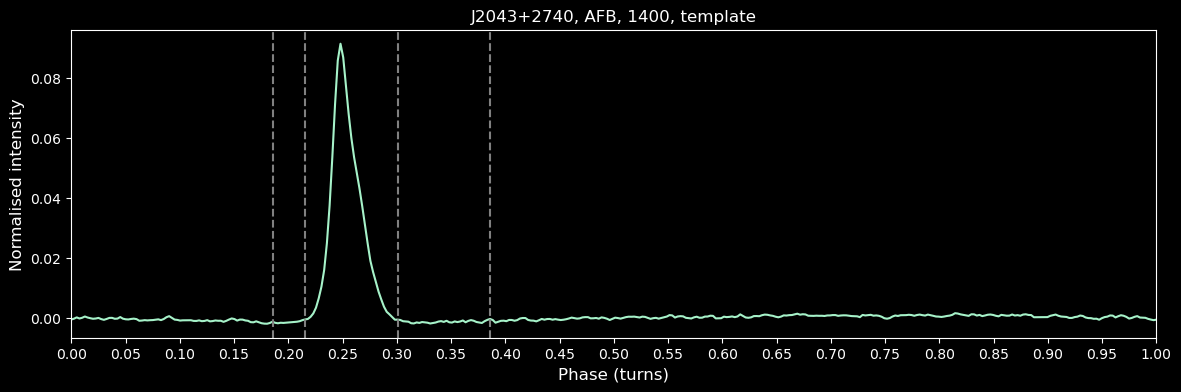

In [10]:
# plot the templates and define some useful values
with plt.style.context(plot_style):
    plt.clf()
    fig = plt.figure(num=1)
    fig.set_size_inches(14, 4)

    plt.title("{}, {}, {}, template".format(psr, BE, freq))
    BE_nbin = len(BE_temp)
    plt.plot(np.linspace(0, 1, BE_nbin), BE_temp, color=c2)

    ylims = plt.ylim()
    plt.vlines([off_min, peak_min, peak_max, off_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
    if ip_exist:
        plt.vlines([ip_min, ip_max], ylims[0], ylims[1], linestyle='dashed', colors='grey')
        
    plt.ylim(ylims)
    plt.xticks(np.linspace(0, 1, 21))
    plt.xlim(0, 1)
    plt.ylabel('Normalised intensity', fontsize=12)
    plt.xlabel('Phase (turns)', fontsize=12)
    plt.savefig(os.path.join(plots_dir, desc+'_template.png'), bbox_inches='tight')
    plt.show()


We first need to fit the profiles to get eigenvalues and eigenvectors. The eigenvectors describe the profiles, including bin-wise dependence. The eigenvalues describe the variation between profiles. Once we have the eigenvalues, we can fit GPs, and then find correlations. 

In [11]:
if exist_BE:
    BE_bins = np.linspace(0, 1, num=BE_aligned.shape[0], endpoint=False)
    BE_mask = np.logical_and(BE_bins > off_min, BE_bins < off_max)
    BE_off = np.logical_or(BE_bins[BE_mask] < peak_min, BE_bins[BE_mask] > peak_max)
    if ip_exist:
        BE_mask = np.logical_or(BE_mask, np.logical_and(BE_bins > ip_min, BE_bins < ip_max))
        BE_off = np.logical_or(BE_bins[BE_mask] < peak_min, np.logical_and(BE_bins[BE_mask] > peak_max, BE_bins[BE_mask] < off_max))
    
    #BE_range = (int(peak_min*BE_nbin), int(peak_max*BE_nbin))
    #BE_range = (0, BE_aligned.shape[0])
    BE_pca = PCA(n_components=30)
    BE_comps_all = BE_pca.fit_transform(BE_aligned[BE_mask,:].T) * BE_offrms.reshape(-1,1)


In [12]:
print("Check that these are number of profiles by number of components:")
if exist_BE:
    print(BE+":", BE_comps_all.shape)
    
print("Check that these are number of components by number of bins (used):")
if exist_BE:
    print(BE+":", BE_pca.components_.shape)


Check that these are number of profiles by number of components:
AFB: (275, 30)
Check that these are number of components by number of bins (used):
AFB: (30, 80)


In [13]:
if exist_BE:
    BE_rms, _ = get_rms_bline(BE_aligned)
    print(len(BE_rms))
    print("The (max, median, and min) off-pulse rms for {} are ({:.5f}, {:.5f}, {:.5f})".format(BE, BE_rms.min(), np.median(BE_rms), BE_rms.max()))


275
The (max, median, and min) off-pulse rms for AFB are (0.40752, 0.91493, 2.78169)


In [14]:
if exist_BE:
    bad_mjds_BE = bad_mjds_eigs(BE_aligned, BE_mjds_new, peak_min, peak_max)
    

200
53767.8064131


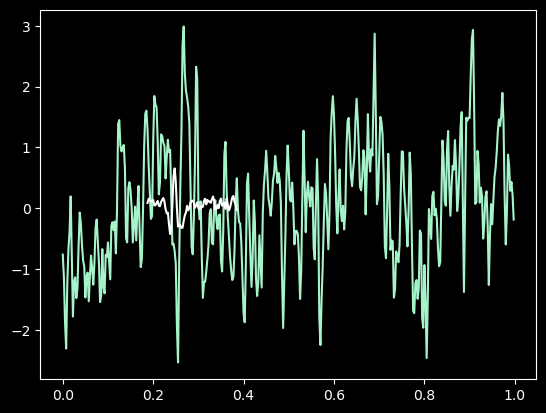

In [15]:
if exist_BE:
    print(len(bad_mjds_BE))
    imjd = np.random.randint(len(bad_mjds_BE))
    bad_mjd = bad_mjds_BE[imjd]
    #lim = BE_mjds_new == bad_mjd
    print(bad_mjd)
    with plt.style.context(plot_style):
        plt.plot(BE_bins, BE_aligned[:,imjd], color=c2)
        plt.plot(BE_bins[BE_mask], BE_pca.mean_, '-', color=c1)
        plt.show()


In [16]:
# define axes parameters for following plots
#w = 0.92
l1 = 0.1
b = 0.1
h = 0.82
sep = 0.08
frac = 0.5
l2 = l1 + frac + sep
w1 = frac
w2 = 1 - l2 - sep

#h1 = (0.87 - sep)/(1 + frac)
#h2 = h1*frac
#b1 = b2 + h2 + sep


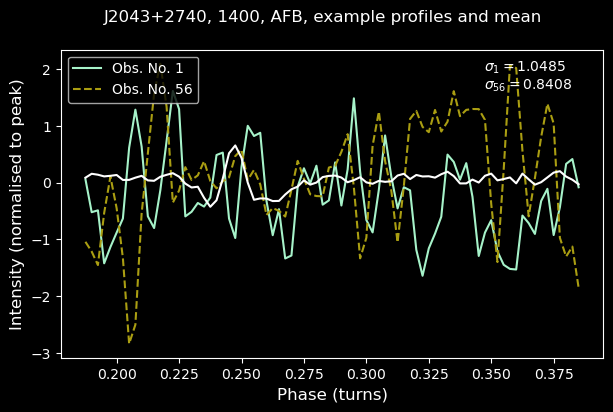

In [17]:
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(7, 4)
        fig.suptitle("{}, {}, {}, example profiles and mean".format(psr, freq, BE))
        first, second = np.random.randint(BE_comps_all.shape[0], size=2)
        if ip_exist:
            ax1 = fig.add_axes((l1, b, w1, h))
            ax2 = fig.add_axes((l2, b, w2, h))
            mask1 = np.logical_and(BE_mask, BE_bins < 0.65)
            mask2 = np.logical_and(BE_mask, BE_bins >= 0.65)
            mean_mask1 = np.arange(len(BE_pca.mean_)) < len(BE_bins[mask1])
            mean_mask2 = np.arange(len(BE_pca.mean_)) >= len(BE_bins[mask1])
            for ax, mask, mmask in zip([ax1, ax2], [mask1, mask2], [mean_mask1, mean_mask2]):
                ax.plot(BE_bins[mask], BE_aligned[mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
                ax.plot(BE_bins[mask], BE_aligned[mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
                ax.plot(BE_bins[mask], BE_pca.mean_[mmask], color=c1) #mean plotted, subtracted off before computing
                ax.set_xlabel('Phase (turns)', fontsize=12)
        
            #ax1.set_xlim()
            ax = ax1

        else:
            ax = plt.gca()
            plt.plot(BE_bins[BE_mask], BE_aligned[BE_mask,first], color=c2, label='Obs. No. {}'.format(first)) #two example profiles of the two states
            plt.plot(BE_bins[BE_mask], BE_aligned[BE_mask,second], color=c3, ls='--', label='Obs. No. {}'.format(second))
            plt.plot(BE_bins[BE_mask], BE_pca.mean_, color=c1) #mean plotted, subtracted off before computing
            plt.xlabel('Phase (turns)', fontsize=12)
    
        #plt.xlim(peak_min*BE_nbin, peak_max*BE_nbin)
        #plt.xlim(BE_range[0], BE_range[1])
        plt.text(0.78, 0.87, '$\sigma_{{{:d}}} = {:.4f}$\n$\sigma_{{{:d}}} = {:.4f}$'.format(first, BE_rms[first], second, BE_rms[second]), transform=ax.transAxes)
        #plt.text(0.025, 0.87, '$N_{{obs,purple}} = {}$\n$N_{{obs,red}} = {}$'.format(first, second), transform=ax.transAxes)
        ax.set_ylabel('Intensity (normalised to peak)', fontsize=12)
        plt.legend(loc=2)
        #plt.savefig(os.path.join(plots_dir, desc+'_ex_profs.png'), bbox_inches='tight')
        plt.show()


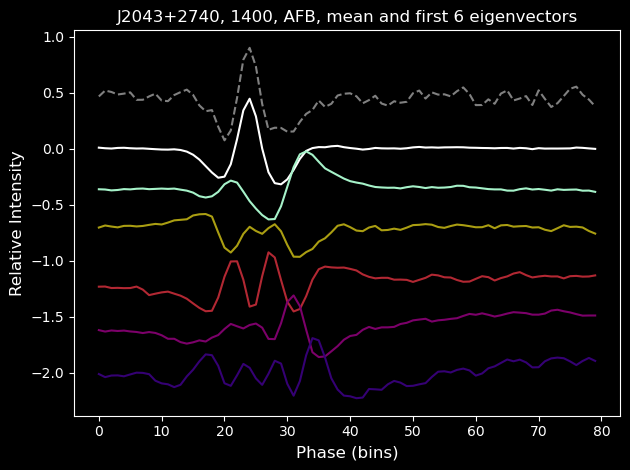

In [18]:
# plot the first five principal components
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, {}, {}, mean and first 6 eigenvectors".format(psr, freq, BE))
        plt.plot(0.5*(BE_pca.mean_/BE_pca.mean_.max())+0.4, color='grey', ls='--')
        plt.plot(BE_pca.components_[0,:], color=c1)
        plt.plot(BE_pca.components_[1,:]-0.4, color=c2)
        plt.plot(BE_pca.components_[2,:]-0.8, color=c3)
        plt.plot(BE_pca.components_[3,:]-1.2, color=c4)
        plt.plot(BE_pca.components_[4,:]-1.6, color=c5)
        plt.plot(BE_pca.components_[5,:]-2, color=c6)
        plt.ylabel("Relative Intensity", fontsize=12)
        plt.xlabel("Phase (bins)", fontsize=12)

        #if BE_range[0] == 0 and BE_range[1] == BE_nbin:
        #plt.xlim(peak_min*BE_nbin, peak_max*BE_nbin)

        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, desc+'_components.png'), bbox_inches='tight')
        plt.show()


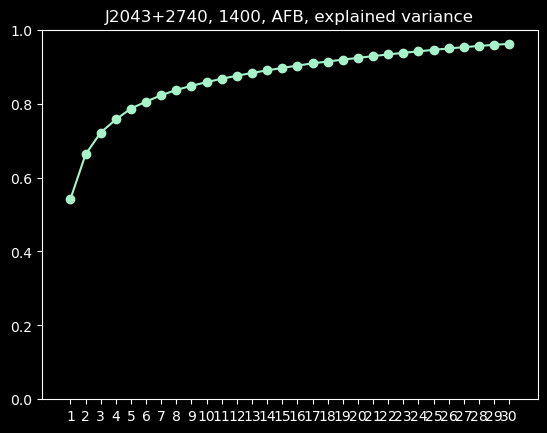

In [19]:
# explained ratio, the variance of each component, and can compute a cumulative sum
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        plt.title("{}, {}, {}, explained variance".format(psr, freq, BE))
        plt.bar(np.arange(1, BE_comps_all.shape[1]+1), BE_pca.explained_variance_ratio_, color='None', edgecolor='k', tick_label=np.arange(1, BE_comps_all.shape[1]+1))
        plt.plot(np.arange(1, BE_comps_all.shape[1]+1), np.cumsum(BE_pca.explained_variance_ratio_[:BE_comps_all.shape[1]+1]), marker='o', color=c2)
        plt.ylim(0, 1)
        plt.savefig(os.path.join(plots_dir, desc+'_variance.png'), bbox_inches='tight')
        plt.show()


In [20]:
if exist_BE:
    #print(BE+":")
    BE_errs_new = err_eigval(BE_aligned[BE_mask,:], BE_pca.components_, BE_off) * BE_offrms.reshape(-1,1)


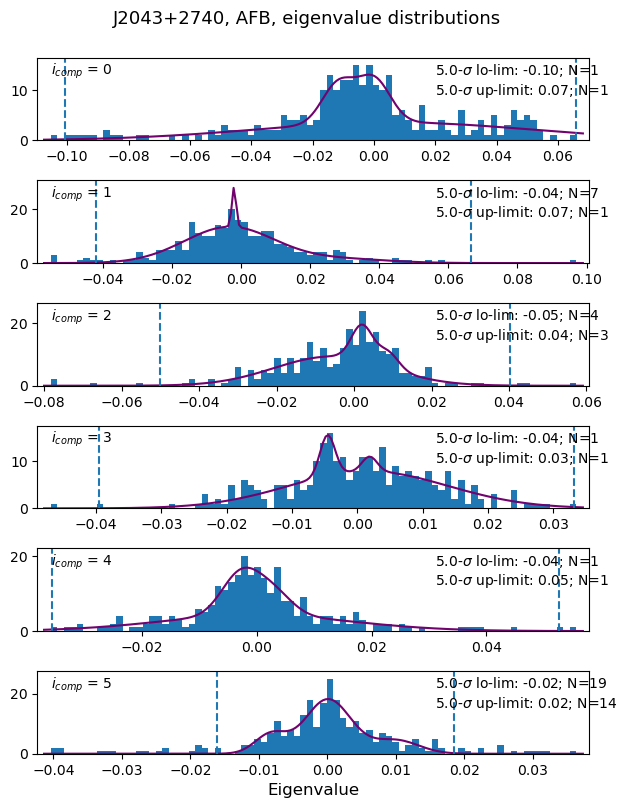

[53867.560742  54084.9556611]


In [21]:
if exist_BE:
    plt.clf()
    BE_mjds_out1 = find_dists_outliers(BE_comps_all, BE_mjds_new, psr, BE, 6, savename=os.path.join(plots_dir, psr+"_BE_{}_eigval_dists.png".format(freq)),
                                        first_out=True, sigma=5)
    BE_mjds_out2 = rolling_out_rej(BE_comps_all, BE_mjds_new, psr, BE, 6, first_out=True, show=False)
    print(BE_mjds_out1)
    #print(BE_mjds_out2)


<Figure size 640x480 with 0 Axes>

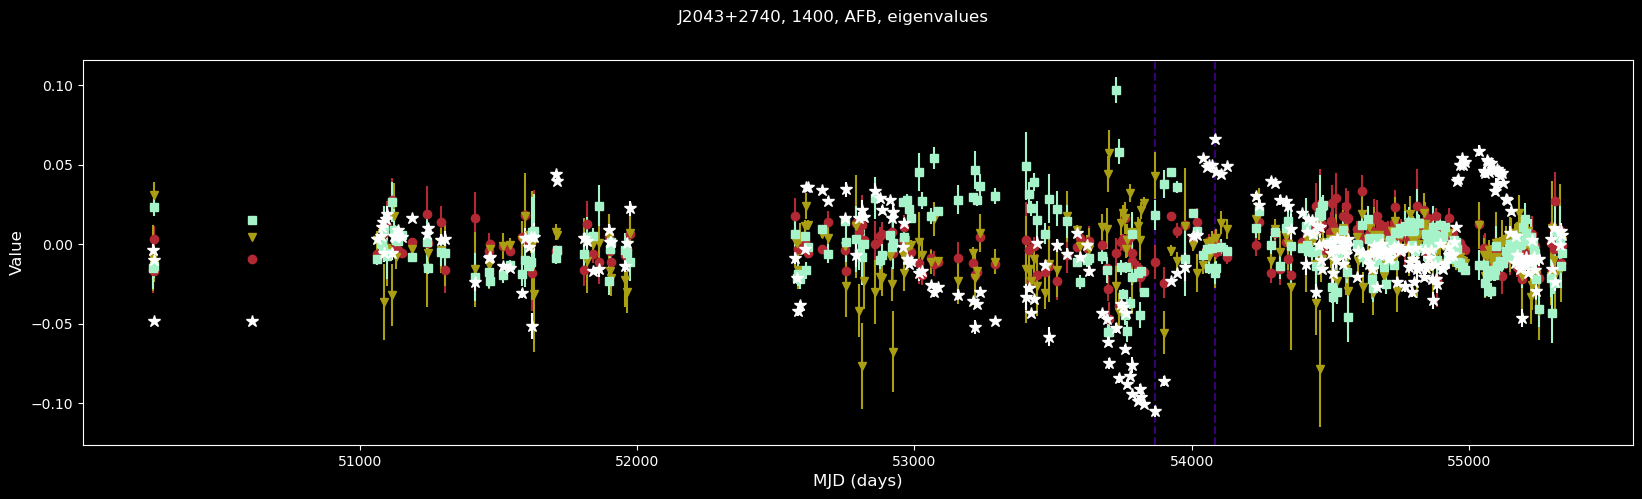

In [22]:
if exist_BE:
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(figsize=(20, 5))
        fig.suptitle("{}, {}, {}, eigenvalues".format(psr, freq, BE))
        ax1 = fig.gca()
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,3], yerr=BE_errs_new[:,3], fmt='o', ecolor=c4, mec=c4, mfc=c4)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,2], yerr=BE_errs_new[:,2], fmt='v', ecolor=c3, mec=c3, mfc=c3)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,1], yerr=BE_errs_new[:,1], fmt='s', ecolor=c2, mec=c2, mfc=c2)
        ax1.errorbar(BE_mjds_new, BE_comps_all[:,0], yerr=BE_errs_new[:,0], fmt='*', ecolor=c1, mec=c1, mfc=c1, ms=9)
        ax1.set_xlabel('MJD (days)', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        vlim = ax1.get_ylim()
        ax1.vlines(BE_mjds_out1, vlim[0], vlim[1], ls='--', color=c6, zorder=1)
        ax1.set_ylim(vlim)
        plt.savefig(os.path.join(plots_dir, desc+"_eigs_v_mjd.png"), bbox_inches='tight')
        plt.show()


53700.921009


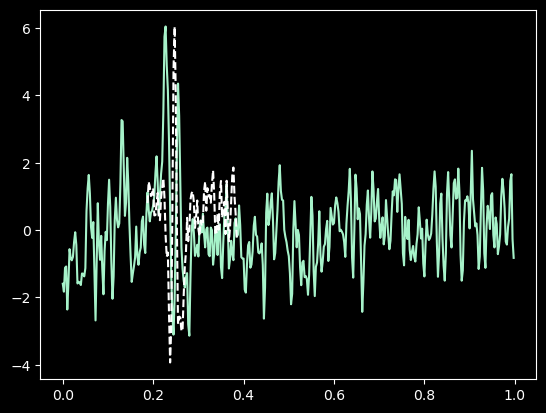

In [23]:
if exist_BE:
    #print(len(BE_mjds_out1))
    #bad_mjd = BE_mjds_out1[12]
    lim = BE_mjds_new > 38000
    imjd = np.argmax(BE_comps_all[:,2][lim])
    bad_mjd = BE_mjds_new[lim][imjd]
    print(bad_mjd)
    with plt.style.context(plot_style):
        plt.clf()
        plt.plot(BE_bins, BE_aligned[:,imjd], color=c2)
        plt.plot(BE_bins[BE_mask], BE_pca.mean_*BE_aligned[:,imjd].max()/BE_pca.mean_.max(), '--', color=c1)
        plt.show()


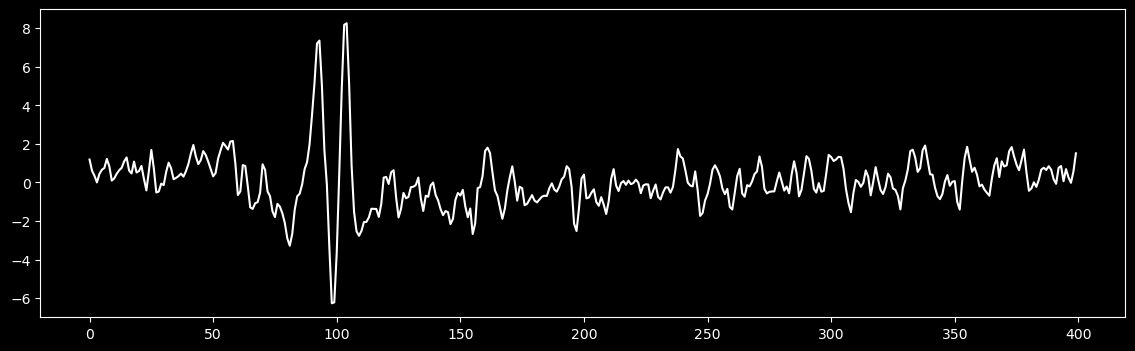

53813.7294453


In [24]:
if exist_BE:
    ncheck = np.random.randint(len(BE_mjds_new))
    #ncheck = 69
    
    with plt.style.context(plot_style):
        plt.clf()
        fig = plt.figure(num=1)
        fig.set_size_inches(14,4)
        plt.plot(BE_aligned[:,ncheck], '-', color=c1)
        plt.show()
        
    print(BE_mjds_new[ncheck])


In [25]:
do_binning = False # change this if desired
# add binning lengths for pulsars into this dictionary; initial guesses from Lyne+2010
bin_lens_dict = {'B1828-11': 100,
                 'B0105+65': 100,
                 'B0329+54': 50,
                 'J0538+2817': 100,
                 'B0740-28': 50,
                 'B0059+65': 100,
                 'B0919+06': 150,
                 'B0950+08': 500,
                 'B1540-06': 400,
                 'B1642-03': 200,
                 'B1714-34': 400,
                 'B1818-04': 400,
                 'B1822-09': 100,
                 'B1826-17': 300,
                 'B1839+09': 300,
                 'B1903+07': 400,
                 'B1907+00': 400,
                 'B1929+20': 400,
                 'B1931+24': 100,
                 'B2035+36': 300,
                 'J2043+2740': 200,
                 'B2148+63': 600}

In [26]:
bin_length = bin_lens_dict[psr] if psr in bin_lens_dict.keys() else 100
bin_overlap = 0.2
if exist_BE and do_binning:
    print(BE+":", BE_comps_all.shape, len(BE_mjds_new))
    try:
        binned_BE, bin_errs_BE, BE_mjds_short = bin_array(BE_comps_all, BE_mjds_new, BE_rms, bin_length, bin_overlap)
    except ValueError:
        print("Trying a longer bin length")
        bin_length *= 2
        binned_BE, bin_errs_BE, BE_mjds_short = bin_array(BE_comps_all, BE_mjds_new, BE_rms, bin_length, bin_overlap)
        
    print(BE+":", binned_BE.shape)
    

In [27]:
if exist_BE and do_binning:
    with plt.style.context(plot_style):
        plt.clf()
        plt.figure(figsize=(20, 4))
        plt.title("{}, {}, {}, binned ({}d, {}% overlap) eigenvalues".format(psr, freq, BE, bin_length, int(bin_overlap*100)))
        plt.plot(BE_mjds_short, binned_BE[:,3]/max(abs(binned_BE[:,3])), 'o', color=c4)
        plt.plot(BE_mjds_short, binned_BE[:,2]/max(abs(binned_BE[:,2])), 'v', color=c3)
        plt.plot(BE_mjds_short, binned_BE[:,1]/max(abs(binned_BE[:,1])), 's', color=c2)
        plt.plot(BE_mjds_short, binned_BE[:,0]/max(abs(binned_BE[:,0])), '*', color=c1, ms=10)
        plt.show()


In [28]:
# Save the eigenvectors and eigenvalues
var_dict = {}#'val_bin_len': bin_length, 'val_bin_lap': bin_overlap}
if exist_BE:
    var_dict[BE+'_errs'] = BE_errs_new
    var_dict[BE+'_mean'] = BE_pca.mean_
    var_dict[BE+'_values'] = BE_comps_all
    var_dict[BE+'_vectors'] = BE_pca.components_
    var_dict[BE+'_mjds'] = BE_mjds_new
    #var_dict[BE+'_bin_vals'] = binned_BE
    #var_dict[BE+'_bin_mjds'] = BE_mjds_short
    var_dict[BE+'_rms'] = BE_rms


In [29]:
out_file = os.path.join(data_dir, '{}_{}_eigs.npz'.format(psr, freq))
if exist_BE:
    old_dict = {}
    if os.path.exists(out_file):
        with np.load(out_file, allow_pickle=True) as f:
            for key in f.keys():
                if key not in var_dict.keys():
                    old_dict[key] = f[key]
                else:
                    print("Replacing an older value for "+key)
                
    np.savez(out_file, **var_dict, **old_dict)


Replacing an older value for AFB_errs
Replacing an older value for AFB_mean
Replacing an older value for AFB_values
Replacing an older value for AFB_vectors
Replacing an older value for AFB_mjds
Replacing an older value for AFB_rms
